In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
import os
import sys

In [6]:
filename_state = {
    12: '/home/ntapia/projects/repos/sleep-rnn/resources/datasets/mass/label/state/01-02-0012 Base.edf',
    13: '/home/ntapia/projects/repos/sleep-rnn/resources/datasets/mass/label/state/01-02-0013 Base.edf',
    19: '/home/ntapia/projects/repos/sleep-rnn/resources/datasets/mass/label/state/01-02-0019 Base.edf',
}
filename_signal = {
    12: '/home/ntapia/projects/repos/sleep-rnn/resources/datasets/mass/register/01-02-0012 PSG.edf',
    13: '/home/ntapia/projects/repos/sleep-rnn/resources/datasets/mass/register/01-02-0013 PSG.edf',
    19: '/home/ntapia/projects/repos/sleep-rnn/resources/datasets/mass/register/01-02-0019 PSG.edf',
}

fs = 200
page_size = 4000
page_duration = 20
state_ids = np.array(['1', '2', '3', '4', 'R', 'W', '?'])
unknown_id = '?'  # Character for unknown state in hypnogram
n2_id = '2'  # Character for N2 identification in hypnogram

In [65]:
subject_id = 19

with pyedflib.EdfReader(filename_state[subject_id]) as file:
    annotations = file.readAnnotations()
with pyedflib.EdfReader(filename_signal[subject_id]) as file:
    channel_names = file.getSignalLabels()
    channel_to_extract = channel_names.index('EEG C3-CLE')
    signal = file.readSignal(channel_to_extract)
    signal_length = signal.size
    signal_length = int(signal_length * fs / file.samplefrequency(channel_to_extract))

In [66]:
# Total pages not necessarily equal to total_annots
total_pages = int(np.ceil(signal_length / page_size))

onsets = np.array(annotations[0])
durations = np.round(np.array(annotations[1]))
stages_str = annotations[2]
# keep only 20s durations
valid_idx = (durations == page_duration)
onsets = onsets[valid_idx]
onsets_pages = np.floor(onsets / page_duration).astype(np.int32)
stages_str = stages_str[valid_idx]
stages_char = [single_annot[-1] for single_annot in stages_str]

# Build complete hypnogram
total_annots = len(stages_char)

not_unkown_ids = [
    state_id for state_id in state_ids
    if state_id != unknown_id]
not_unkown_state_dict = {}
for state_id in not_unkown_ids:
    state_idx = np.where(
        [stages_char[i] == state_id for i in range(total_annots)])[0]
    not_unkown_state_dict[state_id] = onsets_pages[state_idx]
hypnogram = []
for page in range(total_pages):
    state_not_found = True
    for state_id in not_unkown_ids:
        if page in not_unkown_state_dict[state_id] and state_not_found:
            hypnogram.append(state_id)
            state_not_found = False
    if state_not_found:
        hypnogram.append(unknown_id)
hypnogram = np.asarray(hypnogram)

# Extract N2 pages
n2_pages = np.where(hypnogram == n2_id)[0]
# Drop first, last and second to last page of the whole registers
# if they where selected.
last_page = total_pages - 1
n2_pages = n2_pages[
    (n2_pages != 0)
    & (n2_pages != last_page)
    & (n2_pages != last_page - 1)]
n2_pages = n2_pages.astype(np.int16)

alternative_n2_pages = n2_pages

# -------------------------------------------------------------------
# OLD CODE: (debuG)
onsets = np.array(annotations[0])
stages_str = annotations[2]
stages_char = [single_annot[-1] for single_annot in stages_str]
total_annots = len(stages_char)
# Total pages not necessarily equal to total_annots
total_pages = int(np.ceil(signal_length / page_size))
n2_pages_onehot = np.zeros(total_pages, dtype=np.int32)
for i in range(total_annots):
    if stages_char[i] == n2_id:
        page_idx = int(np.round(onsets[i] / page_duration))
        if page_idx < total_pages:
            n2_pages_onehot[page_idx] = 1
n2_pages = np.where(n2_pages_onehot == 1)[0]
# Drop first, last and second to last page of the whole registers
# if they where selected.
last_page = total_pages - 1
n2_pages = n2_pages[
    (n2_pages != 0)
    & (n2_pages != last_page)
    & (n2_pages != last_page - 1)]

n2_pages = n2_pages.astype(np.int32)

In [67]:
np.where(np.array(stages_char) == n2_id)[0][0:10]

array([63, 64, 65, 66, 67, 68, 76, 77, 78, 79])

In [70]:
stages_char[63]

'2'

In [71]:
onsets[63] / page_duration

63.8544668

In [68]:
n2_pages[:10]

array([64, 65, 66, 67, 68, 69, 77, 78, 79, 80], dtype=int32)

In [69]:
alternative_n2_pages[:10]

array([63, 64, 65, 66, 67, 68, 76, 77, 78, 79], dtype=int16)

In [8]:
import sys
sys.path.append('..')
from sleeprnn.data import utils
import numpy as np
import matplotlib.pyplot as plt

In [49]:
def stamp2seq_with_separation(
        stamps, start, end, min_separation_samples, allow_early_end=False):
    """Returns the binary sequence segment from 'start' to 'end',
    associated with the stamps."""
    if np.any(stamps < start):
        msg = 'Values in intervals should be within start bound'
        raise ValueError(msg)
    if np.any(stamps > end) and not allow_early_end:
        msg = 'Values in intervals should be within end bound'
        raise ValueError(msg)

    # Force separation
    stamps = np.sort(stamps, axis=0)
    mod_stamps = [stamps[0, :]]
    for i in range(1, stamps.shape[0]):
        last_stamp = mod_stamps[-1]
        this_stamp = stamps[i, :]
        samples_gap = this_stamp[0] - last_stamp[1] - 1
        if samples_gap < min_separation_samples:
            last_stamp_size = last_stamp[1] - last_stamp[0] + 1
            this_stamp_size = this_stamp[1] - this_stamp[0] + 1
            sum_of_sizes = last_stamp_size + this_stamp_size
            needed_samples = min_separation_samples - samples_gap
            # Proportional elimination of samples
            cut_last = int(np.round(last_stamp_size * needed_samples / sum_of_sizes))
            cut_this = needed_samples - cut_last

            last_stamp[1] = last_stamp[1] - cut_last
            this_stamp[0] = this_stamp[0] + cut_this
            mod_stamps[-1] = last_stamp
            mod_stamps.append(this_stamp)
        else:
            mod_stamps.append(this_stamp)
    mod_stamps = np.stack(mod_stamps, axis=0)

    # Transform modified stamps
    sequence = utils.stamp2seq(mod_stamps, start, end, allow_early_end=allow_early_end)
    return sequence

In [50]:
my_stamps = np.array([
    [3, 10],
    [16, 30],
    [30, 40]
]).astype(np.int32)

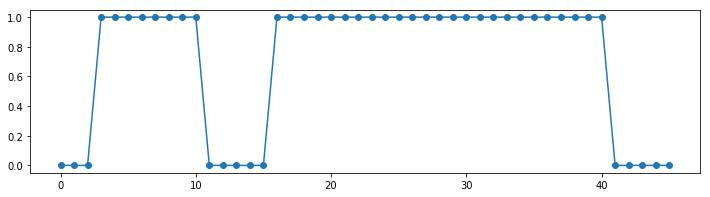

In [51]:
seq_original = utils.stamp2seq(my_stamps, 0, 45)
fig = plt.figure(figsize=(12, 3))
plt.plot(seq_original, marker='o')
plt.show()

[[ 3  9]
 [18 25]
 [34 40]]


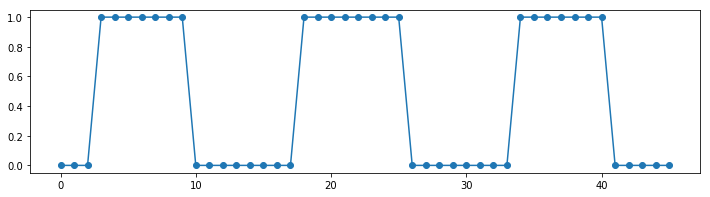

In [52]:
seq_modified = stamp2seq_with_separation(my_stamps, 0, 45, 8)
new_stamps = utils.seq2stamp(seq_modified)
print(new_stamps)
fig = plt.figure(figsize=(12, 3))
plt.plot(seq_modified, marker='o')
plt.show()